In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.options.mode.chained_assignment = None

In [2]:
loops = pd.read_excel('OriginalData/stations.xlsx')

In [3]:
unusedCol = ['Fwy', 'Name', 'District', 'County', 'City', 'CA PM', 'Length', 'Type', 'Sensor Type', 'HOV', 'MS ID', 'IRM']

In [4]:
mainLoops = loops[loops['Type']=="Mainline"]
cellLen = list((np.array(mainLoops['Abs PM']) - np.array(mainLoops['Abs PM'].shift(1)))*1.6)
cellLen[0] = 0
mainLoops['Cell Len(km)'] = cellLen
mainLoops = mainLoops.drop(unusedCol, axis=1)
mainLoops['Link'] = 'Mainline'

onLoops = loops[loops['Type']=="On Ramp"]
onLoops = onLoops.drop(onLoops[onLoops['ID']==717679].index)
onLoops = onLoops.drop(onLoops[onLoops['ID']==717683].index)
onLoops['Cell Len(km)'] = [0]*len(onLoops)
onLoops['Link'] = 'On-ramp'
onLoops = onLoops.drop(unusedCol, axis=1)

offLoops = loops[((loops['Type']=="Off Ramp") | ((loops['Type']=="Fwy-Fwy")))]
offLoops = offLoops.drop(offLoops[offLoops['ID']==717658].index)
offLoops['Cell Len(km)'] = [0] * len(offLoops)
offLoops['Link'] = 'Off-ramp'
offLoops = offLoops.drop(unusedCol, axis=1)

In [5]:
cellType = ['source']
cellType.extend(['cell']*(len(mainLoops)-2))
cellType.append('sink')
cellType.extend(['source']*len(onLoops))
cellType.extend(['sink']*len(offLoops))


topology = {
    'up': [
        [None], [0, 21], [1, 22], [2], [3, 23], [4, 24], [5], [6, 25], [7, 26], [8, 27], [9, 28], [10, 29], [11],
        [12, 30], [13, 31], [14], [15], [16, 32], [17], [18, 33], [19], [None], [None], [None], [None], [None], 
        [None], [None], [None], [None], [None], [None], [None], [None], [3], [4], [6], [8], [9], [11], [16], [18],
        [19]
        
    ],
    'down':[
        [1], [2], [3], [4, 34], [5, 35], [6], [7, 36], [8], [9, 37], [10, 38], [11], [12, 39], [13], [14], [15], 
        [16], [17, 40], [18], [19, 41], [20, 42], [None], [1], [2], [4], [5], [7], [8], [9], [10], [11], [13], [14], [17],
        [19], [None], [None], [None], [None], [None], [None], [None], [None], [None]
    ]
}


cells = pd.concat([mainLoops, onLoops, offLoops])
cells['Type'] = cellType
cells['Up'] = topology['up']
cells['Down'] = topology['down']

cells.reset_index(inplace=True)
cells = cells.drop(['index'], axis=1)

cells.to_csv('Preprocessed Data/cells.csv')

In [6]:
mainVol = dict(); mainSpd = dict()

onVol = dict(); offVol = dict()

In [7]:
for i in mainLoops['ID']:
    loopData = pd.read_excel('OriginalData/stationdata/{}.xlsx'.format(i))
    mainVol[i] = loopData['Flow (Veh/5 Minutes)']
    mainSpd[i] = loopData['Speed (mph)']
    
mainVol = pd.DataFrame(mainVol)
mainSpd = pd.DataFrame(mainSpd)

for j in [mainVol, mainSpd]:
    j.set_index(loopData['5 Minutes'], inplace=True)
    
mainVol = 12*mainVol.transpose() # veh/h
mainSpd = mainSpd.transpose() # mile/h

mainDen = mainVol / (mainSpd+0.0001) # veh/mile

for i in onLoops['ID']:
    loopData = pd.read_excel('OriginalData/stationdata/{}.xlsx'.format(i))
    onVol[i] = loopData['Flow (Veh/5 Minutes)']
onVol = pd.DataFrame(onVol)
onVol.set_index(loopData['5 Minutes'], inplace=True)
onVol = 12*onVol.transpose() # veh/h

for i in offLoops['ID']:
    loopData = pd.read_excel('OriginalData/stationdata/{}.xlsx'.format(i))
    offVol[i] = loopData['Flow (Veh/5 Minutes)']
offVol = pd.DataFrame(offVol)
offVol.set_index(loopData['5 Minutes'], inplace=True)
offVol = 12*offVol.transpose() # veh/h

In [8]:
totalVol = pd.concat([mainVol, onVol, offVol])

totalVol

5 Minutes,5/05/2019 0:00,5/05/2019 0:05,5/05/2019 0:10,5/05/2019 0:15,5/05/2019 0:20,5/05/2019 0:25,5/05/2019 0:30,5/05/2019 0:35,5/05/2019 0:40,5/05/2019 0:45,...,5/11/2019 23:10,5/11/2019 23:15,5/11/2019 23:20,5/11/2019 23:25,5/11/2019 23:30,5/11/2019 23:35,5/11/2019 23:40,5/11/2019 23:45,5/11/2019 23:50,5/11/2019 23:55
717654,5172,5160,4632,4968,4524,4824,4512,4680,4632,4620,...,4020,3480,4068,3228,3372,3096,3756,3120,3624,3240
717659,5496,5532,5088,5100,4860,5208,4740,4944,4968,4632,...,4296,3612,4368,3264,3528,3216,3720,3288,3636,3264
773154,5532,5736,5160,5136,4956,5292,4668,5112,5124,4776,...,4452,3852,4380,3456,3588,3396,3624,3576,3612,3300
717667,5460,5304,4704,4668,4800,4992,4680,4860,4860,4344,...,4356,3684,3972,3264,3528,2964,3252,3456,3396,3444
717672,5796,5820,5184,5388,5364,5544,4416,5376,4908,4644,...,4476,3816,4068,3960,3372,3432,3504,3900,3792,3696
773193,5796,5400,5148,5208,5412,4776,4632,5292,4884,4524,...,4404,3780,4044,3900,3300,3396,3384,3768,3660,3468
761128,5256,5028,4608,4704,4908,4320,4380,4908,4464,4188,...,4116,3768,3636,3852,3024,3312,3096,3408,3252,3168
761141,5232,5124,4320,4812,4980,4236,4368,4872,4428,4272,...,4140,3672,3636,3684,3180,3300,3120,3588,3108,3228
761152,5448,5424,4632,4944,5256,4848,5292,4608,4356,4620,...,3792,3900,3264,3972,3132,3048,2856,3408,2748,3048
761165,5496,5244,4908,4980,5232,5076,5424,4728,4668,5052,...,4332,3924,3456,4248,3564,3300,2988,3816,3108,3456


## Temporal-spatial Speed

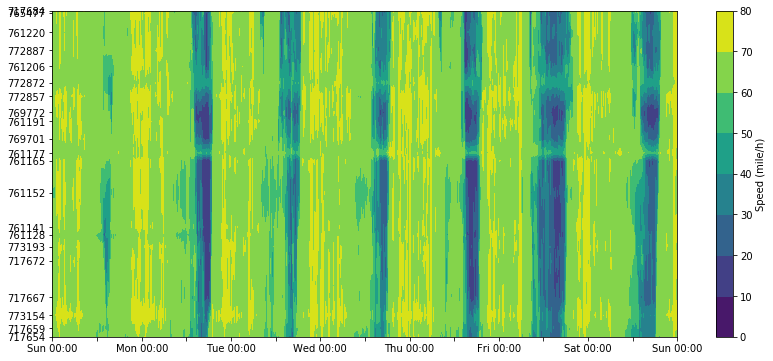

In [9]:
x, y = np.meshgrid(range(2016), mainLoops['Abs PM'])

plt.figure(figsize=(14, 6))
plt.contourf(x, y, mainSpd)

plt.gca().set_yticks(mainLoops['Abs PM'])
plt.gca().set_yticklabels(mainLoops['ID'])

plt.gca().set_xticks([144*i for i in range(15)])
plt.gca().set_xticklabels(['Sun 00:00', '', 'Mon 00:00', '', 'Tue 00:00', '', 'Wed 00:00', '',
                           'Thu 00:00', '', 'Fri 00:00', '', 'Sat 00:00', '', 'Sun 00:00'])

cb = plt.colorbar()
cb.ax.set_ylabel('Speed (mile/h)')

plt.show()

## Fundamental Diagram

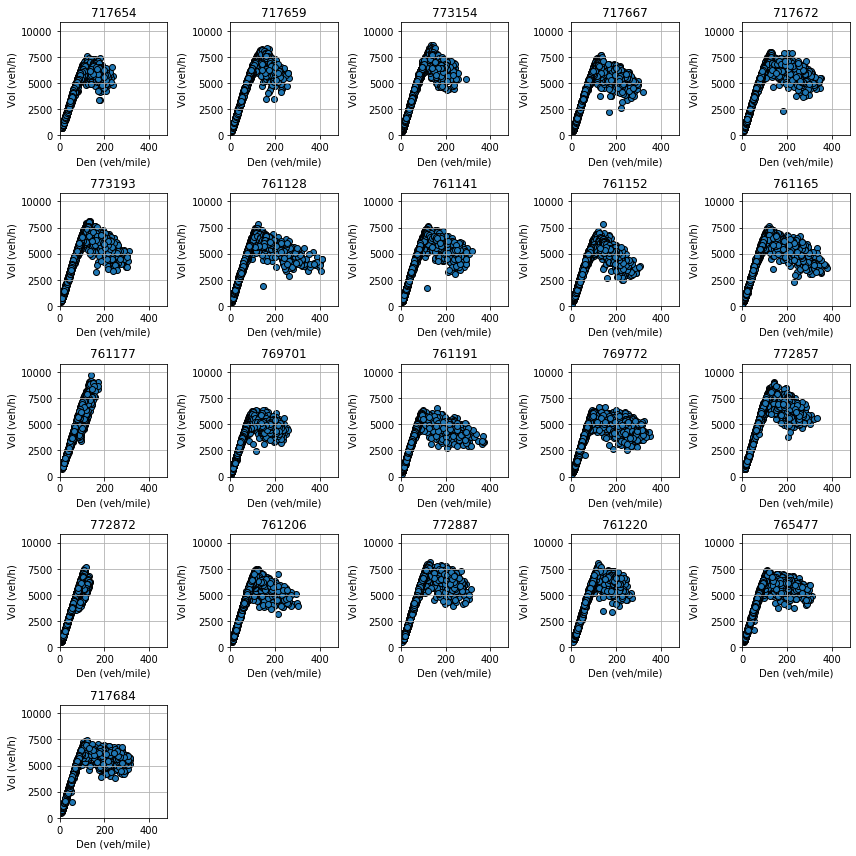

In [10]:
plt.figure(figsize=(12, 12))
for i, j in enumerate(mainLoops['ID']):
    plt.subplot(5, 5, i+1)
    plt.scatter(mainDen.loc[j], mainVol.loc[j], edgecolors='k')
    plt.xlim([0, 480])
    plt.ylim([0, 10800])
    plt.title(j)
    plt.xlabel('Den (veh/mile)')
    plt.ylabel('Vol (veh/h)')
    plt.grid()
    
plt.tight_layout()
plt.show()

## On-ramp flow

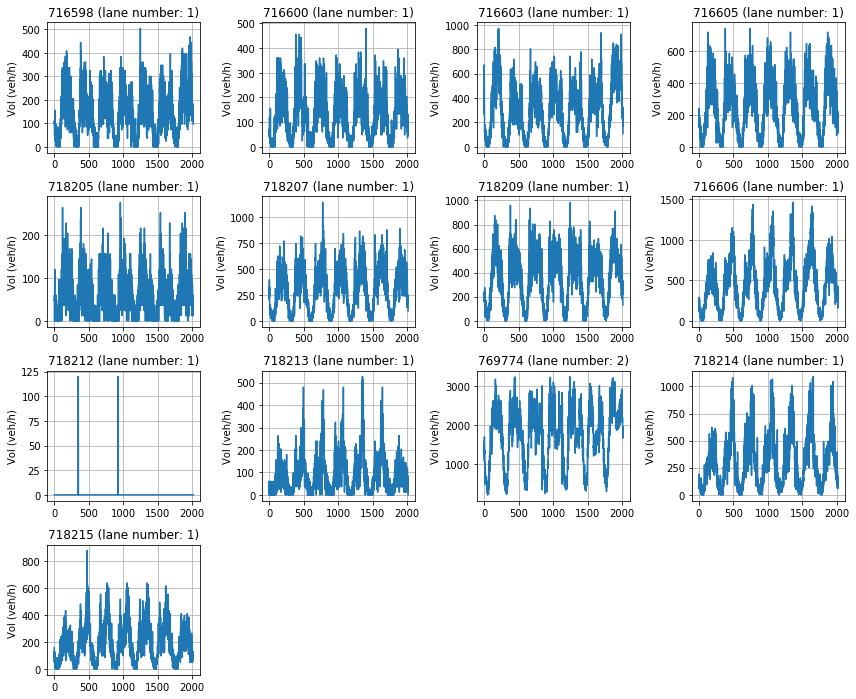

In [11]:
plt.figure(figsize=(12, 12))
for i, j in enumerate(onLoops['ID']):
    plt.subplot(5, 4, i+1)
    plt.plot(range(2016), onVol.loc[j])
    plt.title("{} (lane number: {})".format(j, onLoops[onLoops['ID']==j]['Lanes'].values[0]))
    plt.ylabel('Vol (veh/h)')
    plt.grid()
    
plt.tight_layout()
plt.show()

## Off-ramp flow

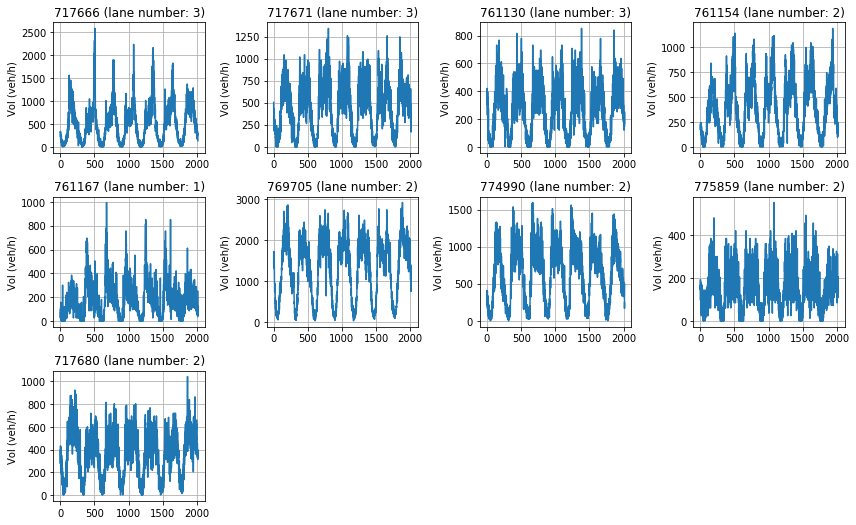

In [12]:
plt.figure(figsize=(12, 12))
for i, j in enumerate(offLoops['ID']):
    plt.subplot(5, 4, i+1)
    plt.plot(range(2016), offVol.loc[j])
    plt.title("{} (lane number: {})".format(j, offLoops[offLoops['ID']==j]['Lanes'].values[0]))
    plt.ylabel('Vol (veh/h)')
    plt.grid()
    
plt.tight_layout()
plt.show()

## Flow Conservation Between Upstream & Downstream

-4.200404392878586
-0.2789266842314429
-0.6847354631321694
-8.675071454238179
5.133517635264453
2.6004252702771944
1.2129212739190889
4.0752881849071985
-2.376590880796976
-3.765949924064458
-0.3744378279210819
-0.908050978763244
0.7990321716843274
5.186025243969783
15.258333111402644
-17.511754345452733
-1.7081020963691813
-1.2088231273920174
3.5673958393140803
0.8572769056834085


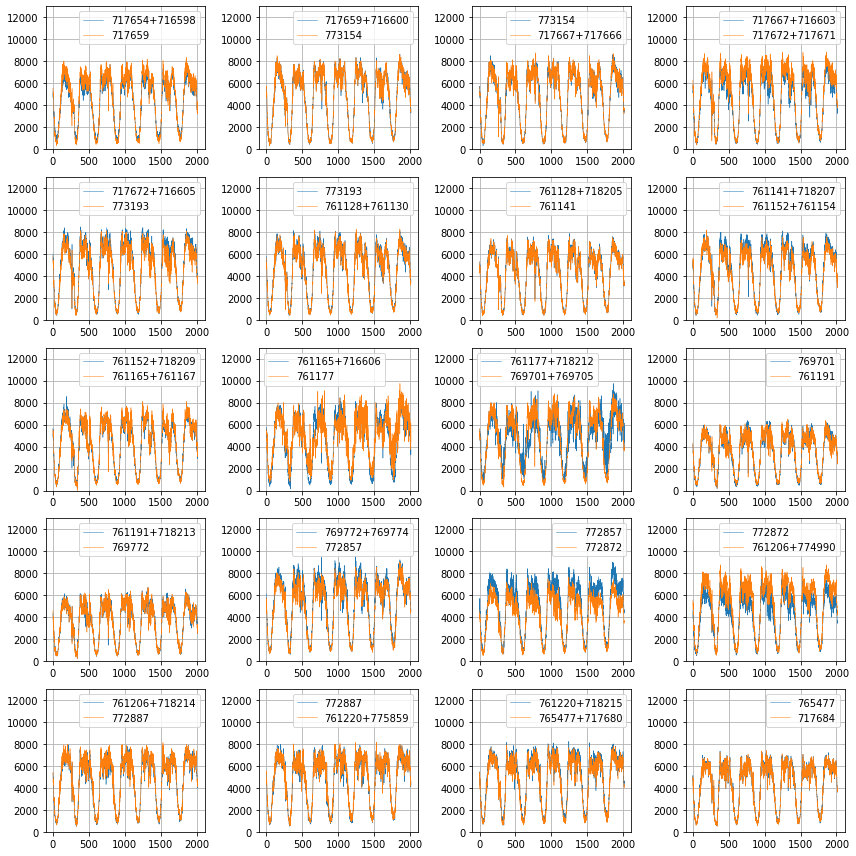

In [53]:
plt.figure(figsize=(12, 12))
for i in range(1, 21):
    upFlow = 0
    upCells = ''
    for upC in cells.loc[i]['Up']:
        upFlow += totalVol.loc[cells.loc[upC]['ID']]
        if upCells == '':
            upCells += '{}'.format(cells.loc[upC]['ID'])
        else:
            upCells += '+{}'.format(cells.loc[upC]['ID'])
        
    downFlow = totalVol.loc[cells.loc[i]['ID']]
    downCells = str(cells.loc[i]['ID'])
    for downC in cells.loc[i]['Down']:
        if downC is not None:
            if cells.loc[downC]['Link'] == 'Off-ramp':
                downFlow += totalVol.loc[cells.loc[downC]['ID']]
                downCells += '+{}'.format(cells.loc[downC]['ID'])
    
    
    plt.subplot(5, 4, i)
    plt.plot(range(2016), upFlow, linewidth=0.5)
    plt.plot(range(2016), downFlow, linewidth=0.5)
    print((np.sum(upFlow)-np.sum(downFlow))/np.sum(upFlow)*100)
    plt.legend([upCells, downCells])
    plt.ylim([0, 13000])
    plt.grid()


plt.tight_layout()
plt.show()

## Off-ramp volume / (off-ramp volume + downstream mainline volume)

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(1, 20):
    plt.subplot(5, 4, i)
    
    if len(cells.loc[i]['Down']) == 1:
        plt.plot([0, 95], [1, 1])
    else:
        downMainFlow = totalVol.loc[cells.loc[i]['ID']]
        for downC in cells.loc[i]['Down']:
            if cells.loc[downC]['Link'] == 'Off-ramp':
                downRampFlow = totalVol.loc[cells.loc[downC]['ID']]
        
        for weekday in range(1, 6):
            _downMainFlow = downMainFlow[(288*weekday+144):(weekday*288+240)]
            _downRampFlow = downRampFlow[(288*weekday+144):(weekday*288+240)]
            plt.plot(range(96), _downRampFlow/(_downRampFlow+_downMainFlow))
    
    plt.title(cells.loc[i]['ID'])
    plt.grid()

plt.tight_layout()
plt.show()

## Calibrating  off-ramp volume / (off-ramp volume+downstream mainline volume)

In [15]:
divergingRatio = {}

for i in range(43):
    currentID = cells.loc[i]['ID']
    if len(cells.loc[i]['Down']) > 1:
        divergingRatio[currentID] = []
        for t in range(16):
            flow = [[], []]
            for downC in cells.loc[i]['Down']:
                if cells.loc[downC]['Link'] == 'Off-ramp':
                    for weekday in range(1, 6):
                        flow[0].extend(totalVol.loc[cells.loc[downC]['ID']][(288*weekday+144+t*6):(288*weekday+150+t*6)])
                else:
                    for weekday in range(1, 6):
                        flow[1].extend(totalVol.loc[cells.loc[downC]['ID']][(288*weekday+144+t*6):(288*weekday+150+t*6)])
            

            toRamp = round(np.mean(np.array(flow[0]) / (np.array(flow[0]) + np.array(flow[1]))), 2)
            toMain = 1 - toRamp
            
            #divergingRatio[currentID].extend([[toRamp, toMain]]*6)
            divergingRatio[currentID].extend([[toMain, toRamp]]*6)

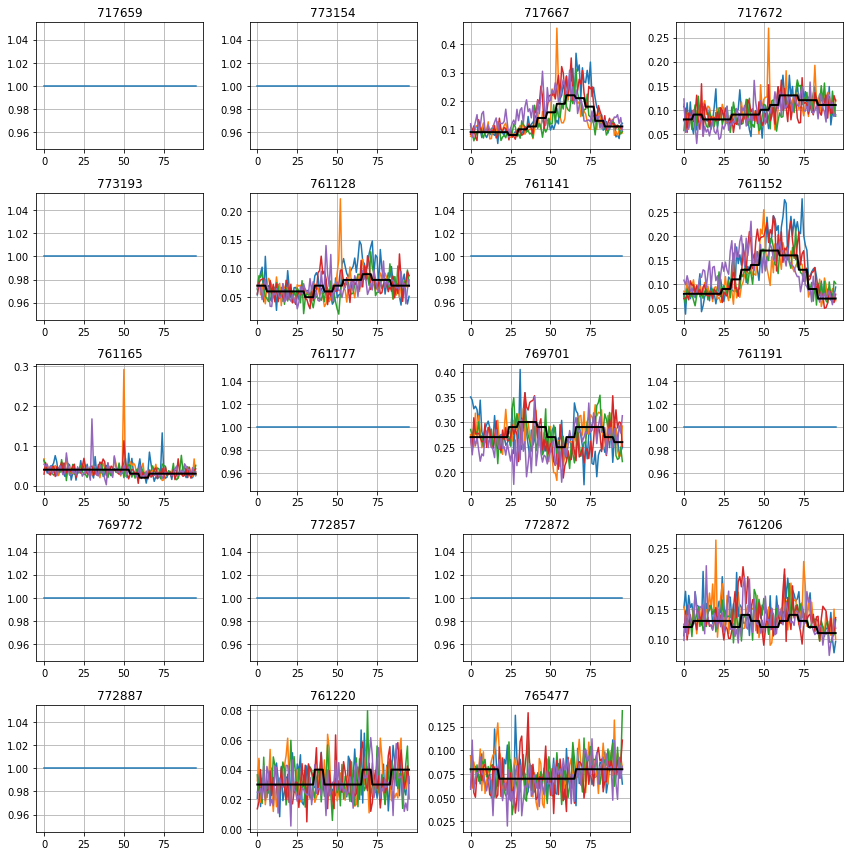

In [18]:
plt.figure(figsize=(12, 12))
for i in range(1, 20):
    plt.subplot(5, 4, i)
    
    if len(cells.loc[i]['Down']) == 1:
        plt.plot([0, 95], [1, 1])
    else:
        downMainFlow = totalVol.loc[cells.loc[i]['ID']]
        for downC in cells.loc[i]['Down']:
            if cells.loc[downC]['Link'] == 'Off-ramp':
                downRampFlow = totalVol.loc[cells.loc[downC]['ID']]
        
        for weekday in range(1, 6):
            _downMainFlow = downMainFlow[(288*weekday+144):(weekday*288+240)]
            _downRampFlow = downRampFlow[(288*weekday+144):(weekday*288+240)]
            plt.plot(range(96), _downRampFlow/(_downRampFlow+_downMainFlow))
        
        plt.plot(range(96), list(zip(*divergingRatio[cells.loc[i]['ID']]))[1], 'k', linewidth=2)
    
    plt.title(cells.loc[i]['ID'])
    plt.grid()

plt.tight_layout()
plt.show()

In [19]:
pd.DataFrame(divergingRatio).transpose().to_csv('OutputData/divergingRatio.csv')

## Throughput

In [18]:
throughput = {}
for i in range(43):
    if cells.loc[i]['Type'] == 'source':
        cellName = cells.loc[i]['ID']
        throughput[cellName] = []
        for weekday in range(1, 6):
            throughput[cellName].extend(totalVol.loc[cellName][(288*weekday+144):(288*weekday+240)])
    
pd.DataFrame(throughput).transpose().to_csv('OutputData/throughput(veh_h).csv')

## Export volume, speed and density

In [19]:
mainSpd *= 1.6 # km/h
mainDen /= 1.6 # veh/km

totalVol.to_csv('OutputData/totalVol(veh_h).csv')
mainSpd.to_csv('OutputData/mainSpd(km_h).csv')
mainDen.to_csv('OutputData/mainDen(veh_km).csv')